# Gaussian process models for stellar variability

By: **Dan Foreman-Mackey**

In this worksheet, we'll take a simulated radial velocity dataset and fit it with a Gaussian Process (GP) model for the stellar variations. Then we will extend this to fit for a simple planet model simultaneously with the GP. Finally, we will briefly demonstrate one method (posterior predictive checks) for testing for the existance of the planet signal.

To start, let's import all the Python modules and set up the environment:

In [152]:
# Set up the plotting to look a little nicer:
%matplotlib inline
%config InlineBackend.figure_format='retina'
from matplotlib import rcParams
rcParams["savefig.dpi"] = 150

# The standard numerical Python modules:
import numpy as np
import matplotlib.pyplot as pl
from scipy.optimize import minimize

# Some other useful modules:
import emcee   # http://dfm.io/emcee
import corner  # https://github.com/dfm/corner.py

For reproducibility, I always like to set the random seed before I start. Feel free to change this:

In [153]:
np.random.seed(42)

Here we'll load the data then split it into a "training set" with 80% of the data and a "validation set" with the rest. For most of the tutorial, we'll only be using the training set but, at the end, the validation set will be used to test for the existance of a planet.

There are 208 training data points and 57 validation datapoints


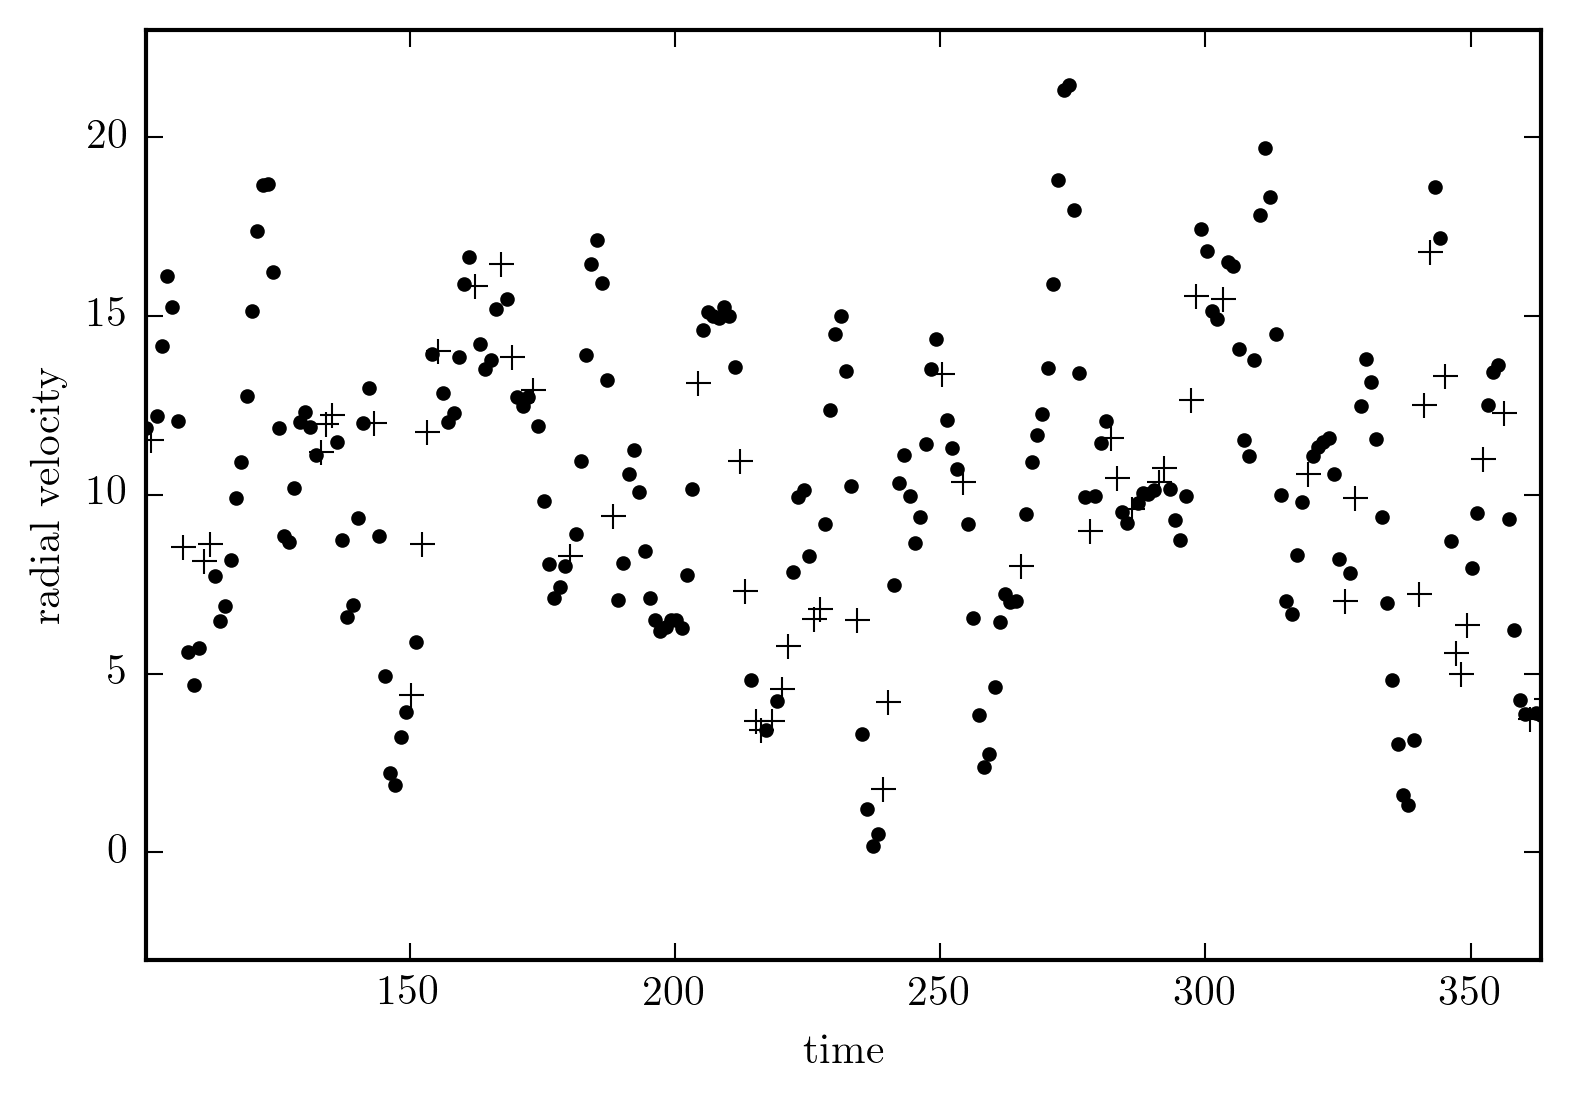

In [154]:
# Load the data:
with open("planet_plus_activity.rdb", "r") as f:
    lines = [line.split() for line in f]
    data = np.array(lines[2:], dtype=float)

# Split into training and validation datasets:
m = np.random.rand(len(data)) < 0.8
training_data = data[m]
validation_data = data[~m]
time, flux, rvel = training_data[:, 0], training_data[:, 1], training_data[:, 2]
print("There are {0} training data points and {1} validation datapoints"
      .format(len(training_data), len(validation_data)))

# Plot the data:
pl.plot(time, rvel, ".k")
pl.plot(validation_data[:, 0], validation_data[:, 2], "+k")
pl.xlim(time.min(), time.max())
pl.ylim(-3, 23)
pl.xlabel("time")
pl.ylabel("radial velocity");

## A GP model for stellar variability

To model the effects of stellar variability, we'll use a quasiperiodic (QP) kernel for the GP. A good choice turns out to be:

$$
k(\Delta t) = \alpha^2\exp\left( -\frac{\Delta t^2}{2\,\tau^2} - \Gamma\,\sin^2\left(\frac{\pi\,\Delta t}{P_\star}\right) \right)
$$

where the parameters have the following effects:

1. $\alpha$ sets the amplitude of the variability,
2. $\tau$ sets the timescale of the oscillation coherence,
3. $\Gamma$ controls the harmonic amplitudes, and
4. $P_\star$ is the period of the oscillations.

In code, this becomes:

In [94]:
def exp2_kernel(tau, dt):
    return np.exp(-0.5 * dt ** 2 / tau)

def expsine2_kernel(gamma, period, dt):
    return np.exp(-gamma * np.sin(np.pi * dt / period) ** 2)

def kernel(params, dt):
    amp, tau, gamma, period = np.exp(params)
    K = amp*amp * exp2_kernel(tau, dt) * expsine2_kernel(gamma, period, dt)
    return K

When you choose a kernel, is always interesting to sample from the prior and investigate the effects of the parameters. Try running the following cell and you'll see a sample from the prior plotted over the data. After you get this, try changing some of the parameters and see how the sample changes – I find $\Gamma$ especially unintuitive. You want to try to find something that is qualitatively "similar" to the data. You might notice that I've added two parameters $\sigma$ (no error bars are provided with the data so we'll also fit for those) and $\mu$ (the bulk [mean] radial velocity of the system).

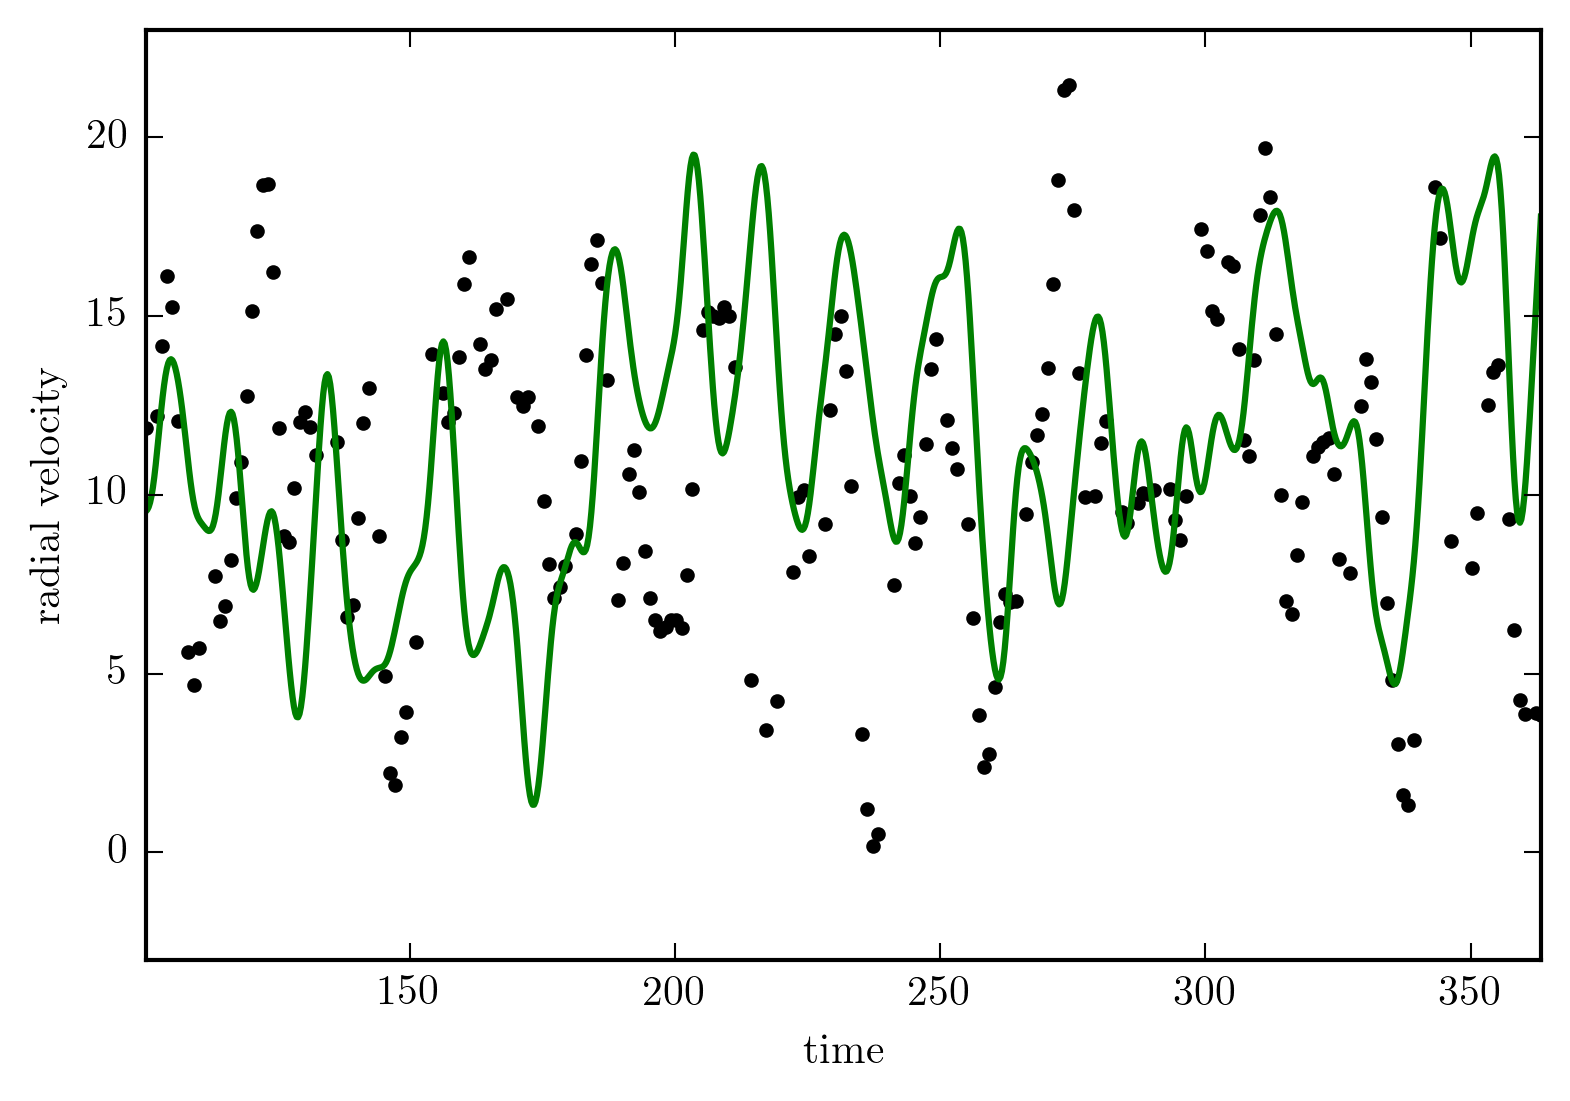

In [155]:
params = np.log([
    0.1,            # estimated error bar
    np.std(rvel),   # kernel amplitude
    50.0,           # correlation length
    0.5,            # gamma
    14.0,           # period
    np.mean(rvel),  # mean
])

x = np.linspace(time.min(), time.max(), 1000)
K = kernel(params[1:-1], x[None, :] - x[:, None])
K[np.diag_indices_from(K)] += 1e-8
y = np.random.multivariate_normal(np.exp(params[-1]) + np.zeros_like(x), K)
pl.plot(time, rvel, ".k")
pl.plot(x, y.T, "g", lw=1.5)
pl.xlim(time.min(), time.max())
pl.ylim(-3, 23)
pl.xlabel("time")
pl.ylabel("radial velocity");

## Fitting the RV curve with the GP only

Next we need to specify the probabilistic model. To do this, we must specify the log prior and log likelihood functions. For the GP model, the log likelihood is given (up to a constant) by the following function where `x` is an array of times and `resid` is the residual of the measured RV away from the mean:

In [98]:
def log_likelihood(params, x, resid):
    # Compute the covariance matrix:
    K = kernel(params[1:5], x[:, None] - x[None, :])
    K[np.diag_indices_from(K)] += np.exp(2 * params[0])
    
    # Compute the log likelihood:
    ll = -0.5 * np.dot(resid, np.linalg.solve(K, resid))
    ll -= 0.5 * np.linalg.slogdet(K)[1]
    return ll

For simplicity, we'll choose uniform priors on the logarithms of the GP hyperparameters and a uniform prior on the bulk velocity between 0 m/s and 25 m/s:

In [117]:
def gp_log_prior(params):
    # Make sure that the parameters are all finite:
    if not np.all(np.isfinite(params)):
        return -np.inf
    
    # Hyperparameter bounds:
    if np.any(params[:5] < -5) or np.any(params[:5] > 5):
        return -np.inf
    
    # Put a tighter bound on gamma:
    if not -1 <= params[3] <= 0.5:
        return -np.inf
    
    # Put a maximum bound of the oscillation period of 100.0:
    if params[4] > np.log(100.0):
        return -np.inf
    
    # Bounds on the mean:
    if not 0 <= params[5] <= 25:
        return -np.inf
    
    # If all the parameters are within the bounds, we can return any finite constant:
    return 0.0

Putting these together, we can compute the log posterior probability up to a constant:

In [118]:
def gp_log_probability(params, x, y):
    lp = gp_log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    resid = y - params[5]
    return lp + log_likelihood(params, x, resid)

It's always good to start with a good guess for the parameters of the model. I'll provide a good guess here but feel free to play around with it a bit. After specifying the guess, we'll optimize to try to get an estimate of the maximum *a posteriori* parameters (Note: this will depend sensitively on your choice of starting parameters):

In [123]:
params = np.log([
    0.1,            # estimated error bar
    np.std(rvel),   # kernel amplitude
    50.0,           # correlation length
    0.5,            # gamma
    14.0,           # period
    np.mean(rvel),  # mean
])

print("Initial log probability: {0:.3f}".format(gp_log_probability(params, time, rvel)))

nlp = lambda p: -gp_log_probability(p, time, rvel)
bounds = [(-4.99, 4.99) for _ in range(len(params))]
bounds[3] = (-0.99, 0.49)
bounds[5] = (0.01, 24.99)
result = minimize(nlp, params, bounds=bounds)
ml_params = result.x
print("Final log probability: {0:.3f}".format(-result.fun))

Initial log probability: -180.993
Final log probability: -61.581


The last component of the model that will come in handy is a method for computing a prediction of the radial velocity function for a given set of parameters. For a GP model, this is given by the following function where the prediction is made at the times `x0`:

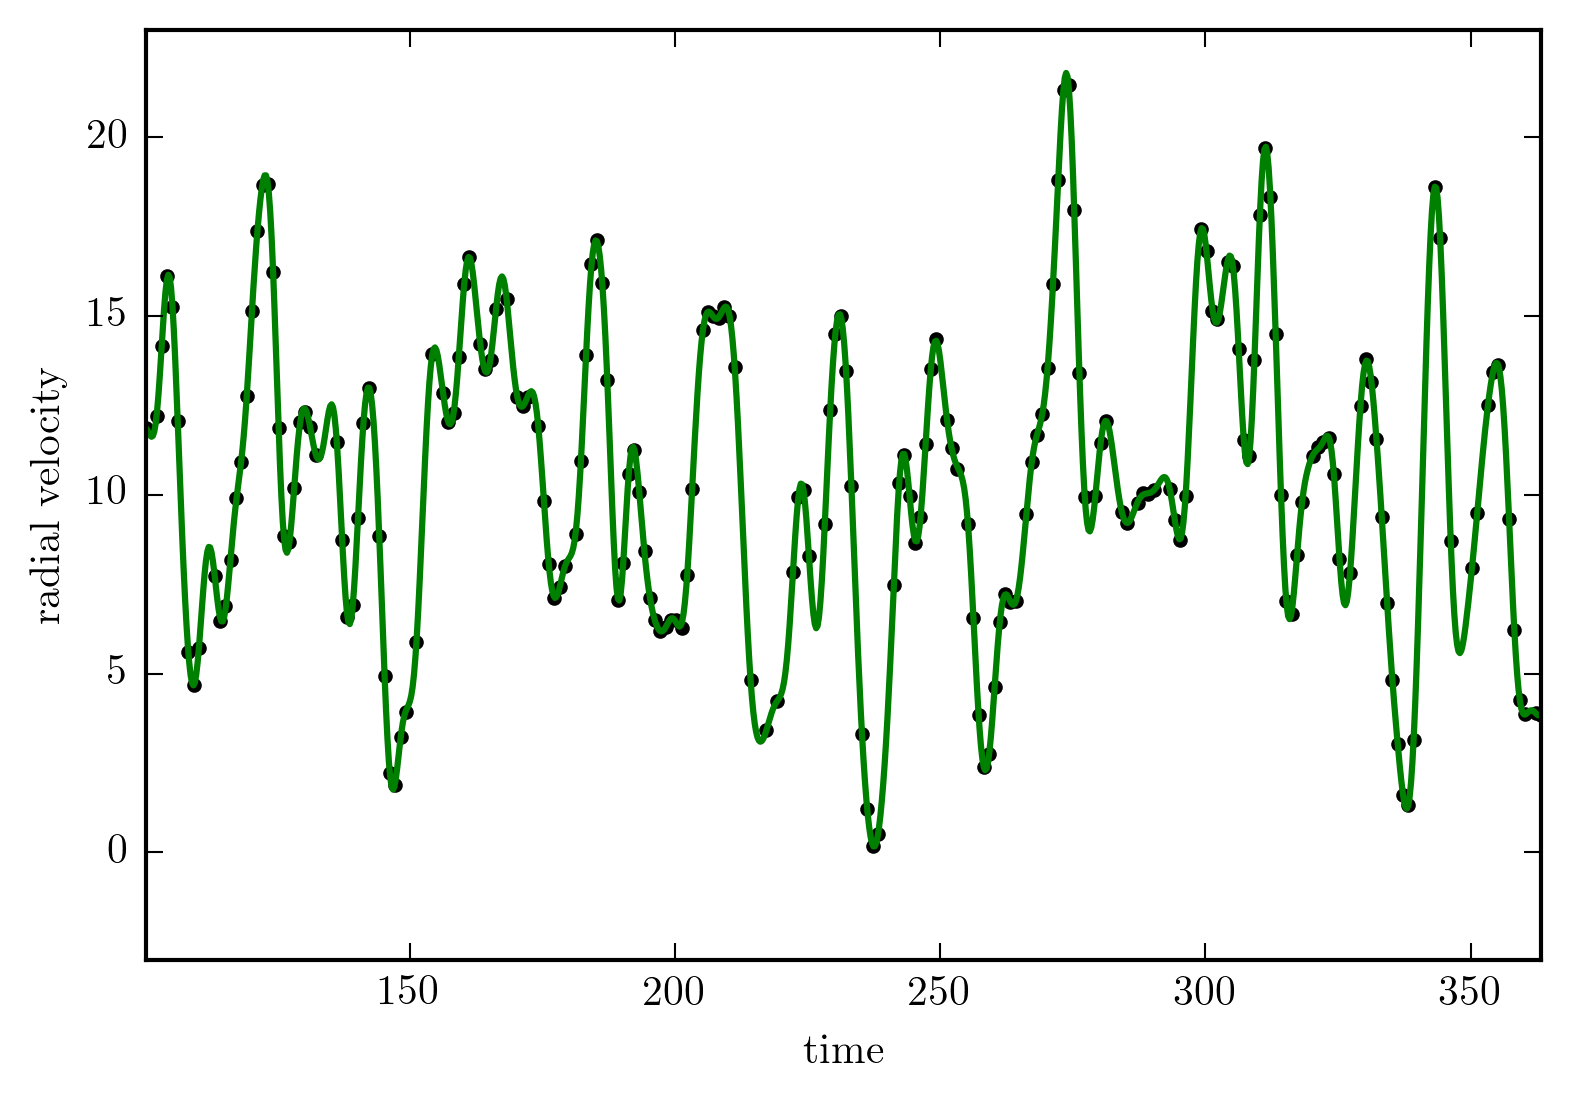

In [156]:
def predict(x0, params, x, resid):
    # Compute the covariance matrices:
    K = kernel(params[1:5], x[:, None] - x[None, :])
    K[np.diag_indices_from(K)] += np.exp(2 * params[0])
    Ks = kernel(params[1:5], x0[:, None] - x[None, :])
    Kss = kernel(params[1:5], x0[:, None] - x0[None, :])
    
    mu = np.dot(Ks, np.linalg.solve(K, resid))
    cov = Kss + np.dot(Ks, np.linalg.solve(K, Ks.T))
    return mu, cov

def gp_predict(x0, params, x, y):
    resid = y - params[5]
    mu, cov = predict(x0, params, x, resid)
    return mu + params[5], cov

# Plot the prediction for the maximum likelihood parameters:
x = np.linspace(time.min(), time.max(), 1000)
mu, _ = gp_predict(x, ml_params, time, rvel)
pl.plot(time, rvel, ".k")
pl.plot(x, mu, "g", lw=1.5)
pl.xlim(time.min(), time.max())
pl.ylim(-3, 23)
pl.xlabel("time")
pl.ylabel("radial velocity");

Now that we have a good intiial guess, let's sample from the posterior probability function using MCMC. The practical details of how to do MCMC are beyond the scope of this tutorial but the following procedure should be fairly reliable. Be warned that when you run this cell, it will probably take a few minutes to complete.

In [125]:
ndim, nwalkers = len(ml_params), 32

# Initialize the "walkers" in a ball around the best fit parameters from above:
p0 = ml_params + 1e-8 * np.random.randn(nwalkers, ndim)

# Set up the sampler and run the first burn-in:
gp_sampler = emcee.EnsembleSampler(nwalkers, ndim, gp_log_probability, args=(time, rvel))

print("Running burn-in #1...")
pos, lp, _ = gp_sampler.run_mcmc(p0, 300)

# Re-sample the walkers around the best sample after burn-in:
pos = pos[np.argmax(lp)] + 1e-8 * np.random.randn(nwalkers, ndim)
gp_sampler.reset()

print("Running burn-in #2...")
pos, _, _ = gp_sampler.run_mcmc(pos, 300)
gp_sampler.reset()

print("Running production chain...")
pos, _, _ = gp_sampler.run_mcmc(pos, 1000);

Running burn-in #1...
Running burn-in #2...
Running production chain...


A good way to visualize the results is to show predictive samples plotted over the data. We'll choose 25 random samples from the chain and plot the prediction:

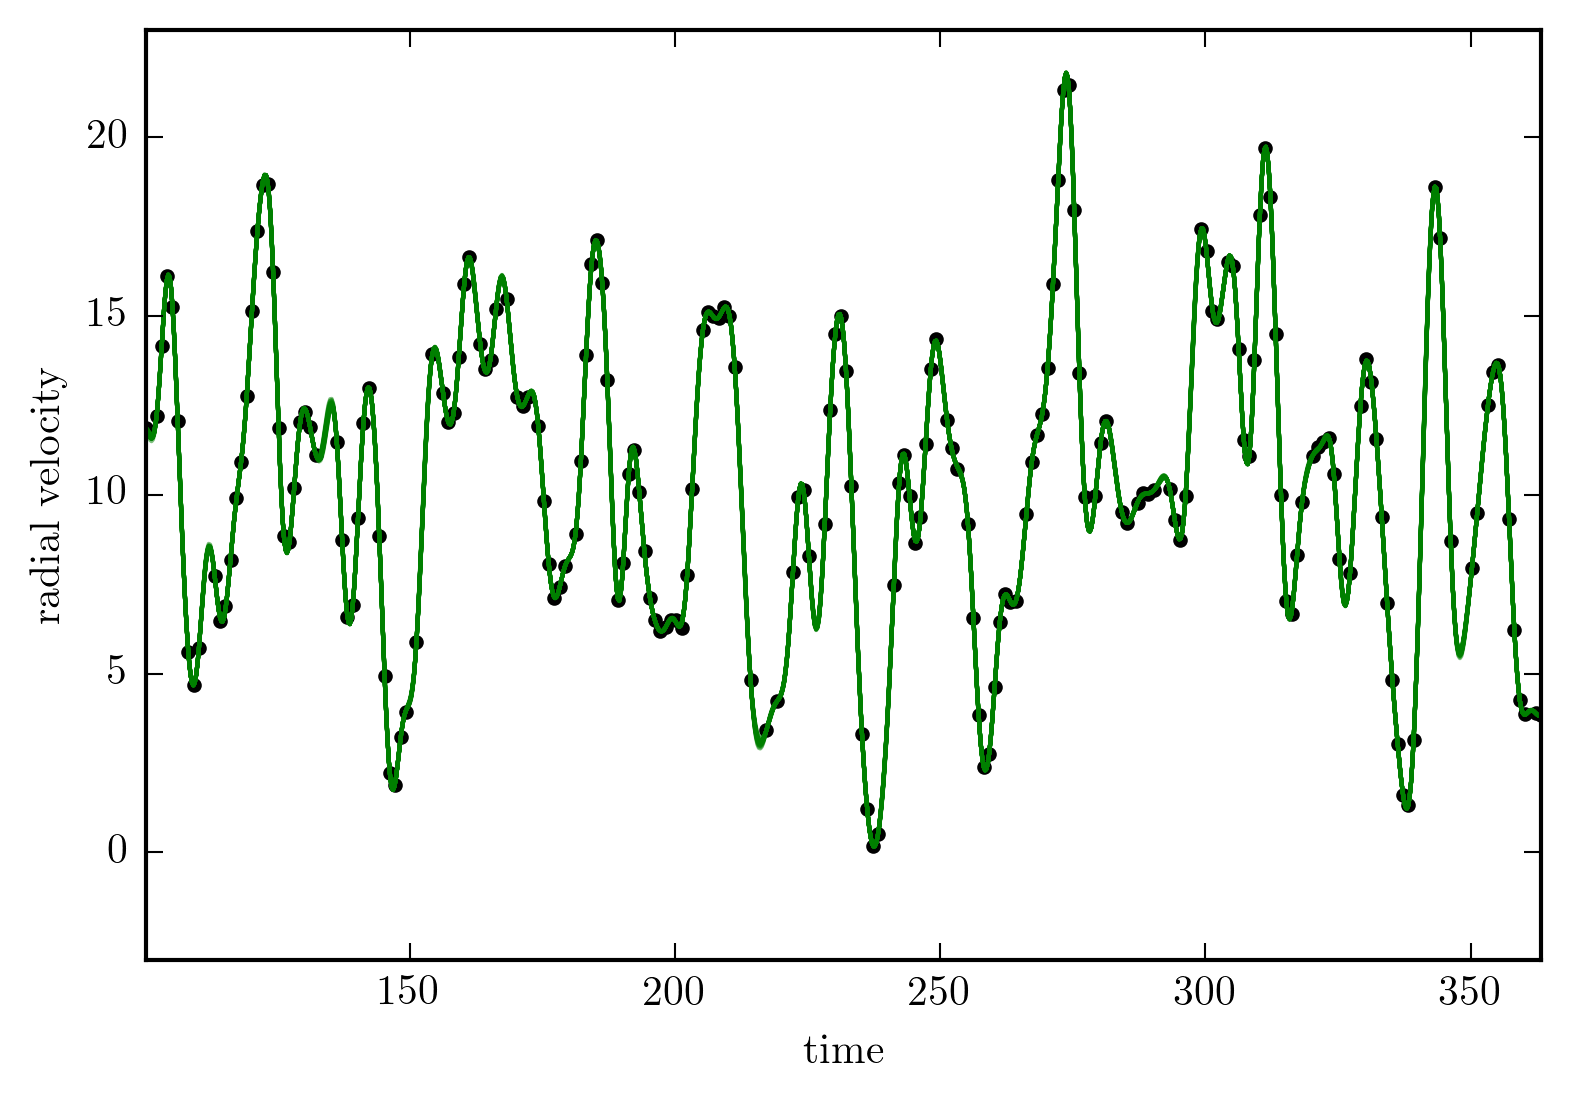

In [157]:
x = np.linspace(time.min(), time.max(), 1000)
pl.plot(time, rvel, ".k")
gp_samples = gp_sampler.flatchain
for i in np.random.randint(len(gp_samples), size=25):
    mu, _ = gp_predict(x, gp_samples[i], time, rvel)
    pl.plot(x, mu, "g", alpha=0.5)
pl.xlim(time.min(), time.max())
pl.ylim(-3, 23)
pl.xlabel("time")
pl.ylabel("radial velocity");

You'll notice that these predictions are all qualitatively consistent (we'll quantify this later) but the spread in predictions grows a little bit when there is less data.

Now let's plot the constraints on the parameters from this MCMC run:

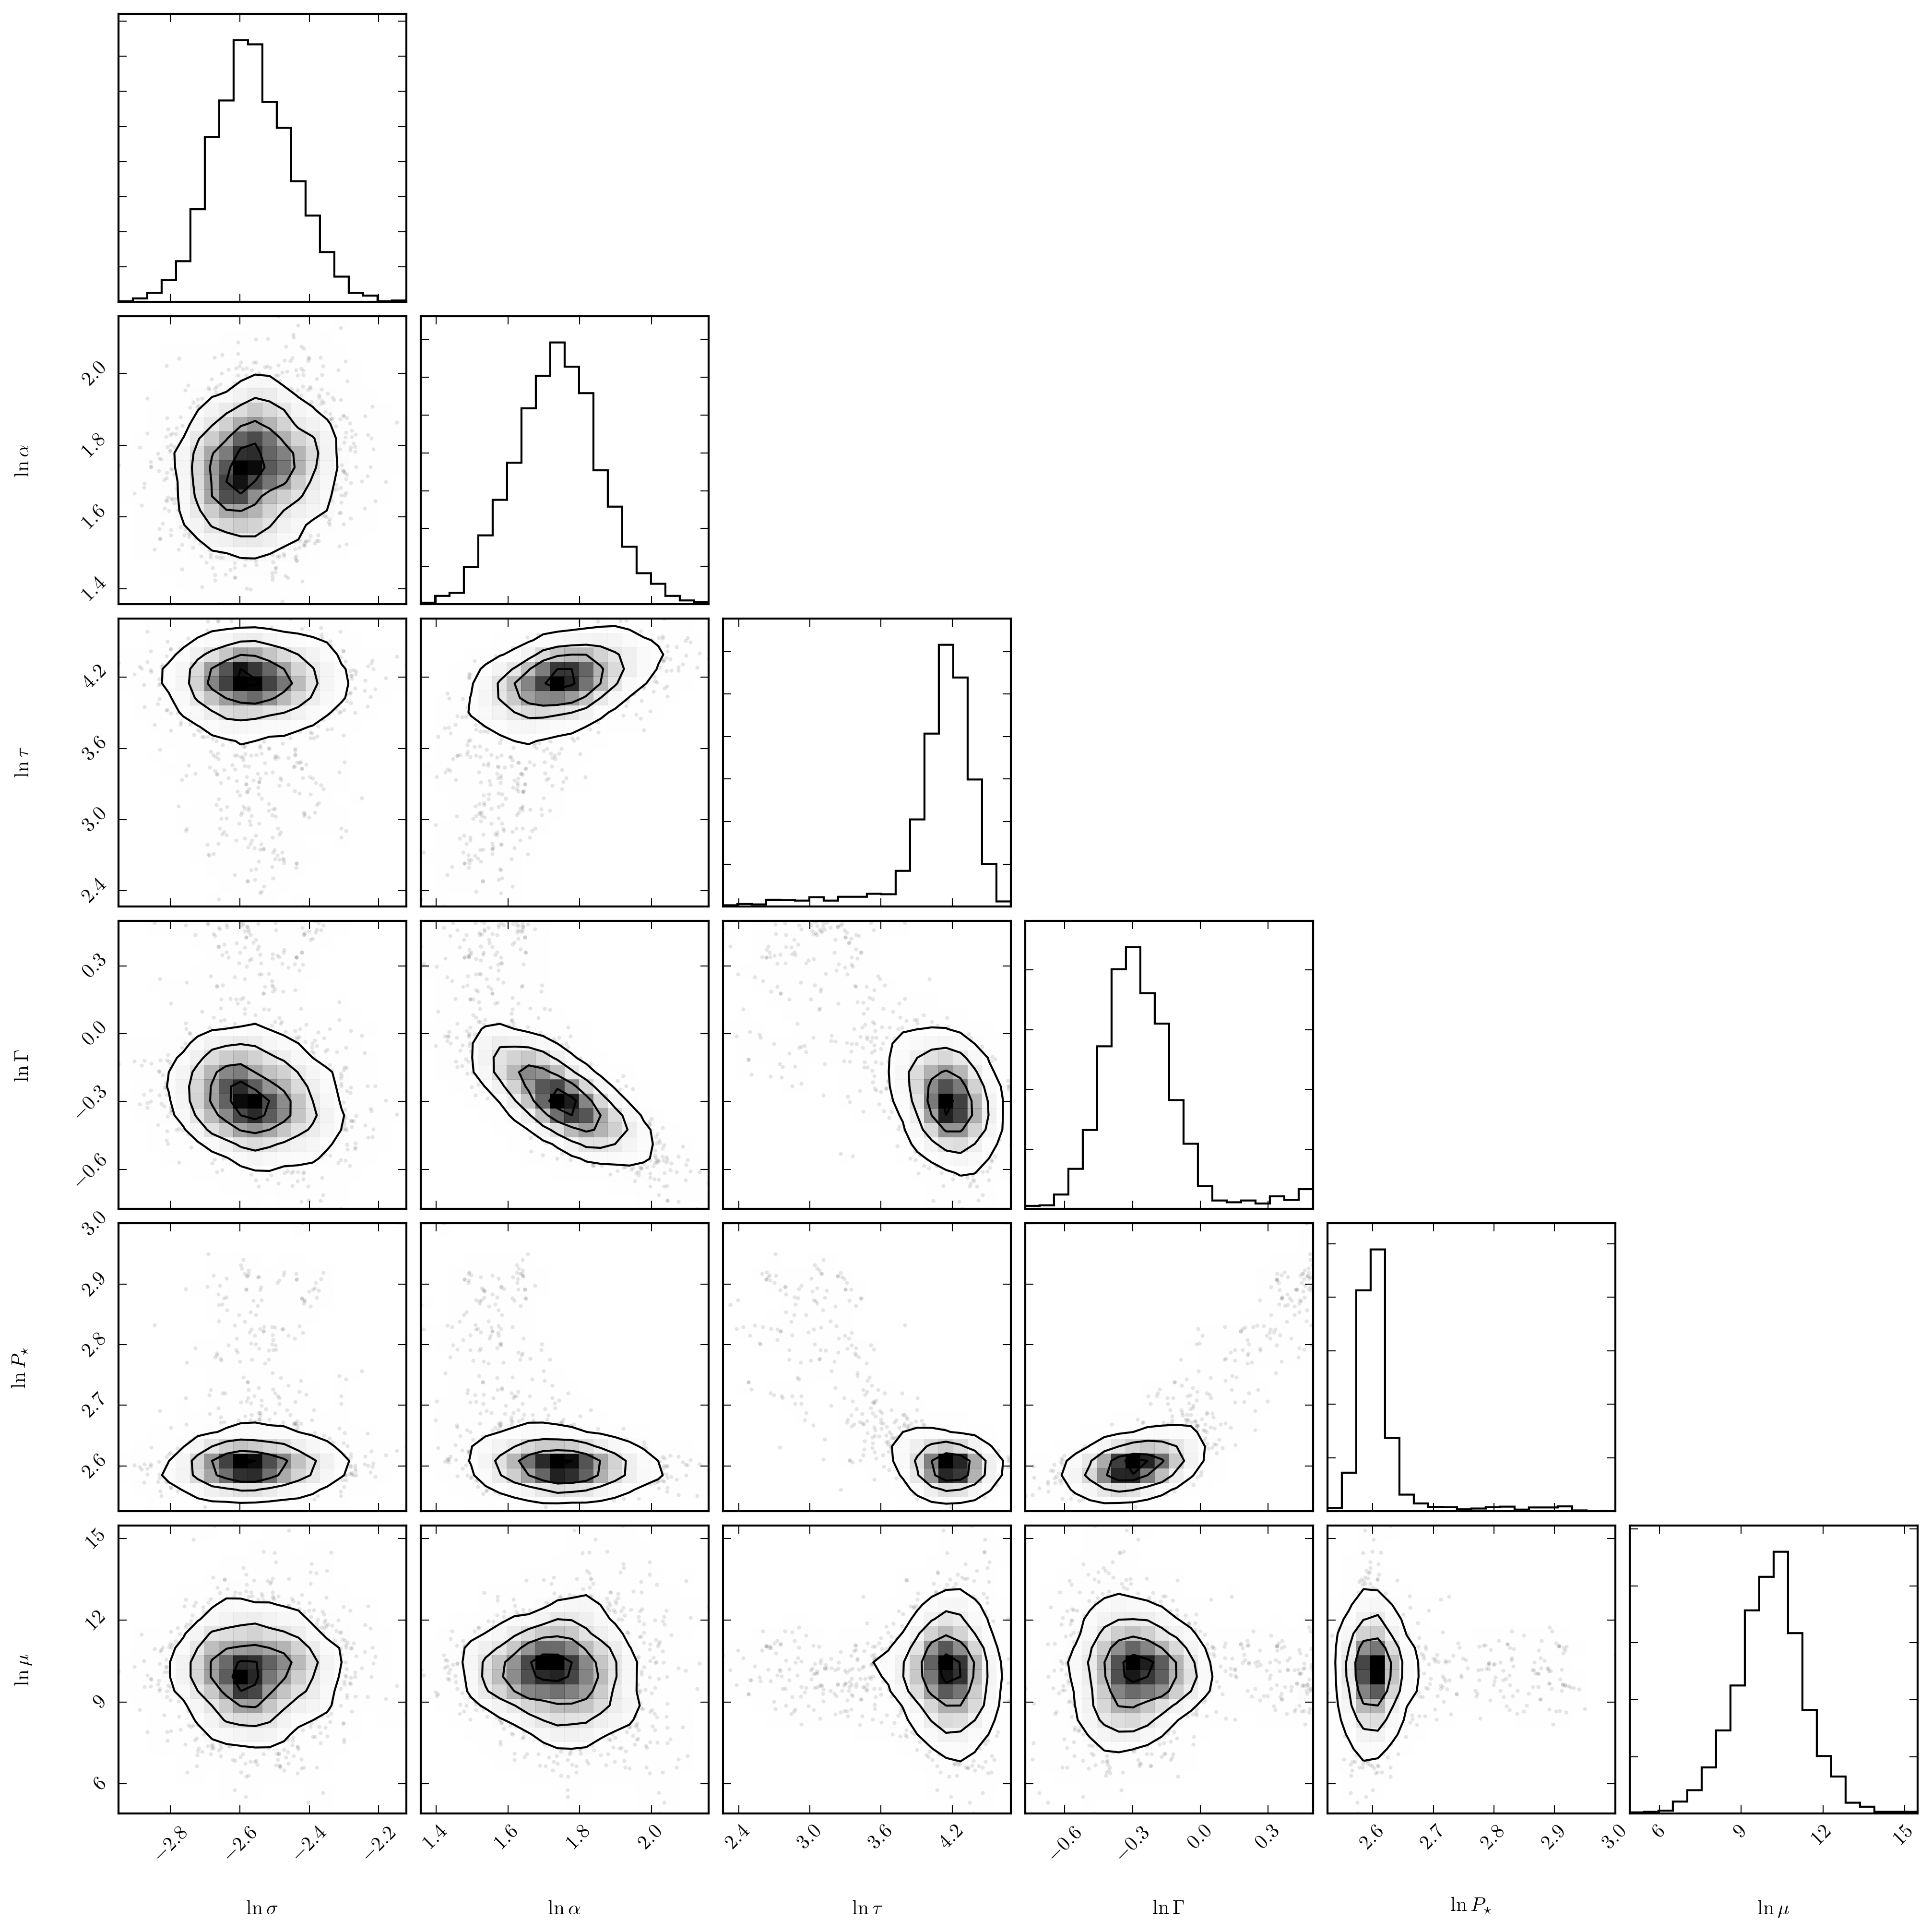

In [159]:
gp_labels = [r"$\ln \sigma$", r"$\ln \alpha$", r"$\ln \tau$", r"$\ln \Gamma$", r"$\ln P_\star$", r"$\ln \mu$"]
corner.corner(gp_sampler.flatchain[::13], labels=gp_labels, smooth=0.7);

## Fitting the RV curve with a GP and a planet simultaneously

Now we'll fit the data using the QP-GP model combined with a simple planet model. The planet model that we'll use is:

$$
m(t) = v_0 + a\,\sin\left(\frac{2\,\pi\,t}{P}\right) + b\,\cos\left(\frac{2\,\pi\,t}{P}\right)
$$

In this model, $a = K\,\cos\omega$ and $b = K\,\sin\omega$ where $K$ is the semi-amplitude. Therefore, if we want a flat prior on $K$, we must specify the prior:

$$
p(a,\,b) = \frac{1}{\sqrt{a^2 + b^2}} = \frac{1}{K} \quad.
$$

Since the period distribution is multi-modal, we will also put a reasonably tight constraint on the orbital period of the planet based on the periodogram: $9.8 < P < 10.2\,\mathrm{days}$ but if you analyze a different dataset, you'll probably need to change these bounds.

The GP + planet model is implemented as follows:

In [228]:
def planet_log_prior(params):
    # First, re-use the GP prior from before:
    lp = gp_log_prior(params[:6])
    if not np.isfinite(lp):
        return -np.inf

    # Then check the bounds for the planet parameters:
    log_period = params[8]
    if not np.log(9.8) <= log_period <= np.log(10.2):
        return -np.inf
    K = np.sqrt(params[6]**2 + params[7]**2)
    if not np.exp(params[0]) <= K <= 10:
        return -np.inf
    
    return lp - np.log(K)

def planet_model(params, x):
    rv0, amp1, amp2 = params[:3]
    twopiw = 2*np.pi*x*np.exp(-params[3])  # 2 pi t / period
    return amp1 * np.sin(twopiw) + amp2 * np.cos(twopiw) + rv0

def planet_log_probability(params, x, y):
    lp = planet_log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    resid = y - planet_model(params[5:], x)
    return lp + log_likelihood(params, x, resid)

def planet_predict(x0, params, x, y):
    resid = y - planet_model(params[5:], x)
    mu, cov = predict(x0, params, x, resid)
    return mu + planet_model(params[5:], x0), cov

To sample, we need to choose a reasonable inital guess for the planet parameters. To do that, we can compute the maximum likelihood $a$ and $b$ for a fixed period and fixed set of hyperparameters. Since we know the planet's period based on the periodogram, we can use that value (10) initially:

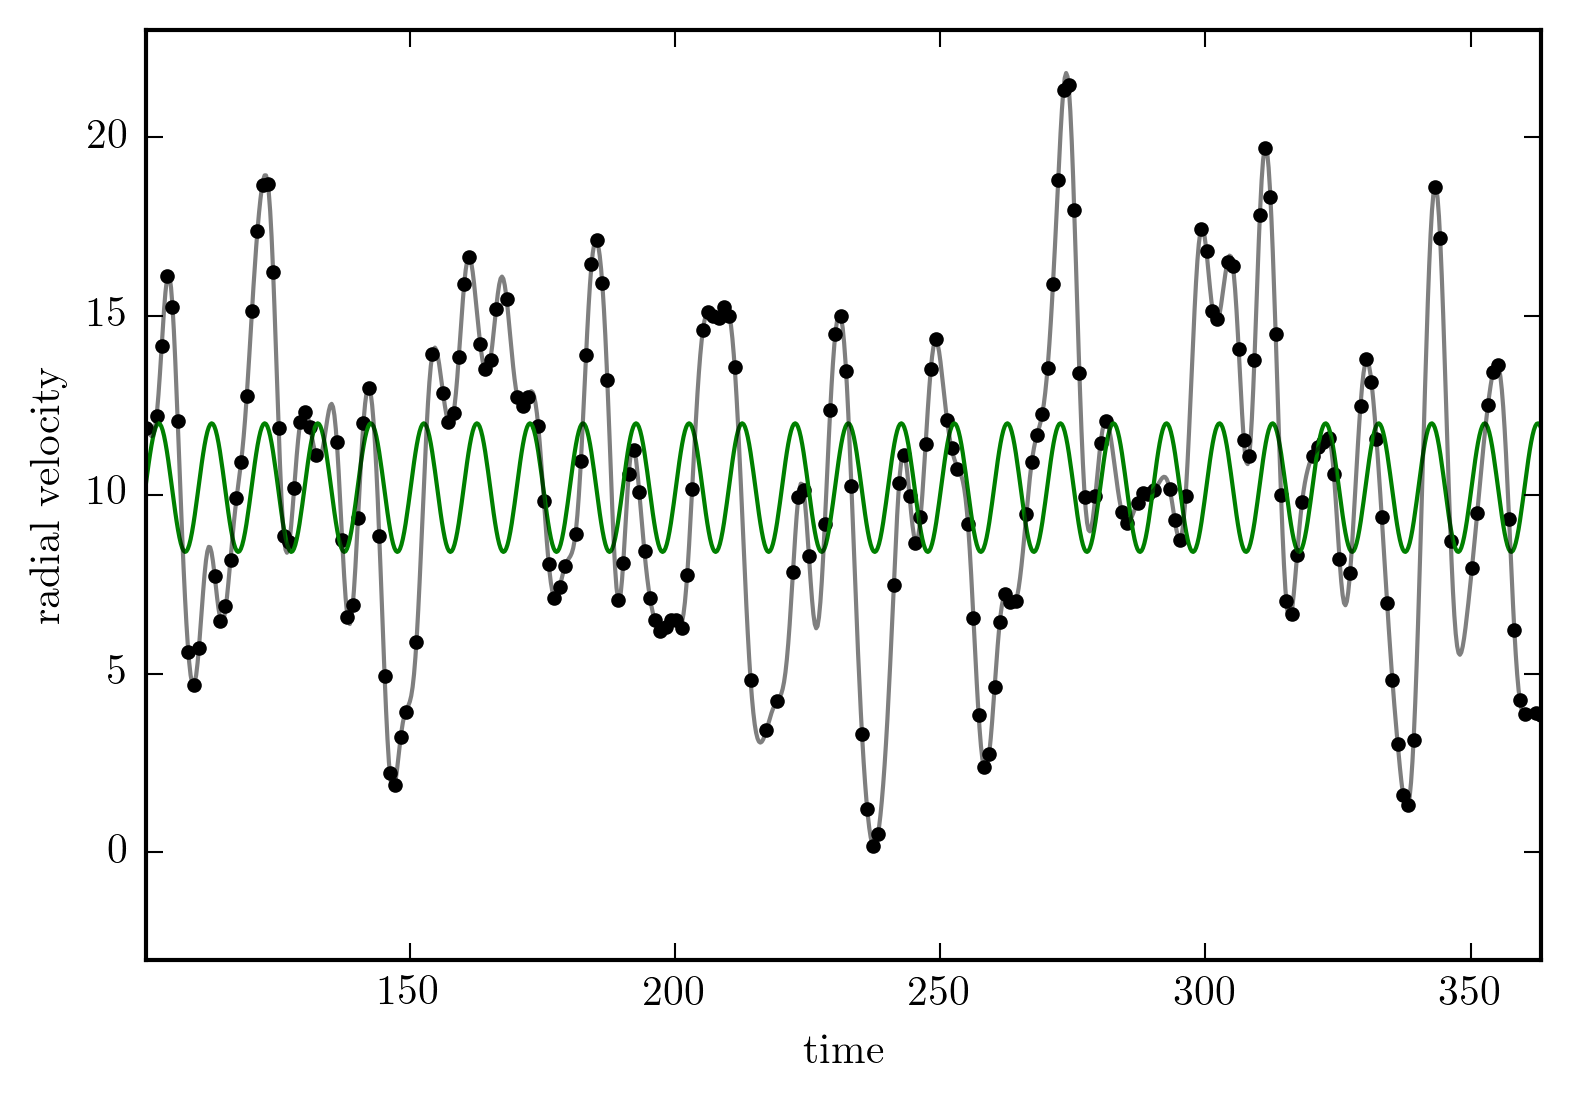

In [230]:
# Compute the maximum likelihood a, b, and rv0 using that fact that this is a linear model
# for fixed period and GP hyperparameters:
period = 10.0
median_params = np.median(gp_samples, axis=0)
K = kernel(median_params[1:5], time[:, None] - time[None, :])
K[np.diag_indices_from(K)] += np.exp(2 * median_params[0])
A = np.vstack((np.ones_like(time), np.sin(2*np.pi*time/period), np.cos(2*np.pi*time/period))).T
w = np.linalg.solve(np.dot(A.T, np.linalg.solve(K, A)), np.dot(A.T, np.linalg.solve(K, rvel)))
planet_params = np.concatenate((median_params[:-1], w, [np.log(period)]))

# Plot the prediction for the maximum likelihood parameters:
x = np.linspace(time.min(), time.max(), 1000)
pl.plot(time, rvel, ".k")
pl.plot(x, planet_model(planet_params[5:], x), "g")
pl.plot(x, planet_predict(x, planet_params, time, rvel)[0], "k", alpha=0.5)
pl.xlim(time.min(), time.max())
pl.ylim(-3, 23)
pl.xlabel("time")
pl.ylabel("radial velocity");

In that plot, you can see that the amplitude of the stellar variability is substantially larger than the signal from the planet. Still, if we assume that the planet exists, we can still sample from the posterior probability to constrain the period and the semi-amplitude. The sampling procedure here is nearly identical to the previous MCMC run but we take more samples here because there are more parameters:

In [221]:
ndim, nwalkers = len(planet_params), 32

# Initialize the "walkers" in a ball around the best fit parameters from above:
p0 = planet_params + 1e-8 * np.random.randn(nwalkers, ndim)

# Set up the sampler and run the first burn-in:
planet_sampler = emcee.EnsembleSampler(nwalkers, ndim, planet_log_probability, args=(time, rvel))

print("Running burn-in #1...")
pos, lp, _ = planet_sampler.run_mcmc(p0, 500)

# Re-sample the walkers around the best sample after burn-in:
pos = pos[np.argmax(lp)] + 1e-8 * np.random.randn(nwalkers, ndim)
planet_sampler.reset()

print("Running burn-in #2...")
pos, _, _ = planet_sampler.run_mcmc(pos, 500)
planet_sampler.reset()

print("Running production chain...")
pos, _, _ = planet_sampler.run_mcmc(pos, 1500);

Running burn-in #1...
Running burn-in #2...
Running production chain...


As before, we can plot the results of this sampling by overplotting the predicted model on the data and plotting the parameter constraints:

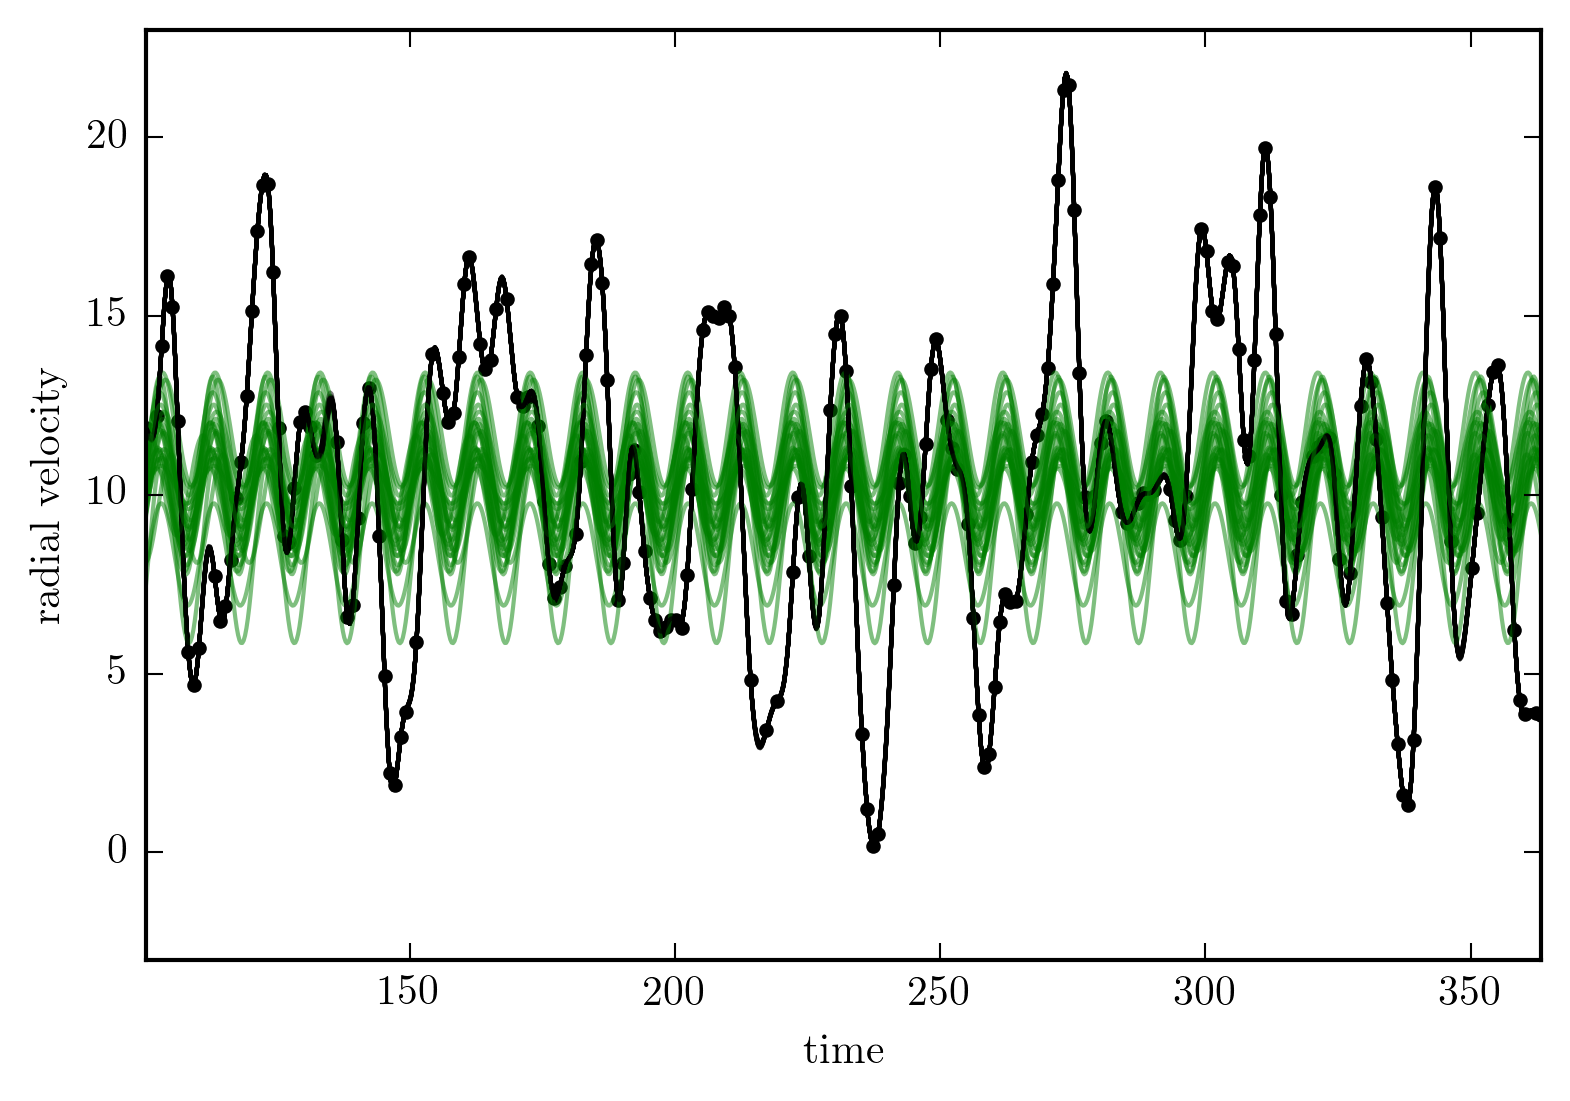

In [222]:
x = np.linspace(time.min(), time.max(), 1000)
pl.plot(time, rvel, ".k")
planet_samples = planet_sampler.flatchain
for i in np.random.randint(len(planet_samples), size=25):
    mu, _ = planet_predict(x, planet_samples[i], time, rvel)
    pl.plot(x, mu, "k", alpha=0.5)
    pl.plot(x, planet_model(planet_samples[i, 5:], x), "g", alpha=0.5)
pl.xlim(time.min(), time.max())
pl.ylim(-3, 23)
pl.xlabel("time")
pl.ylabel("radial velocity");

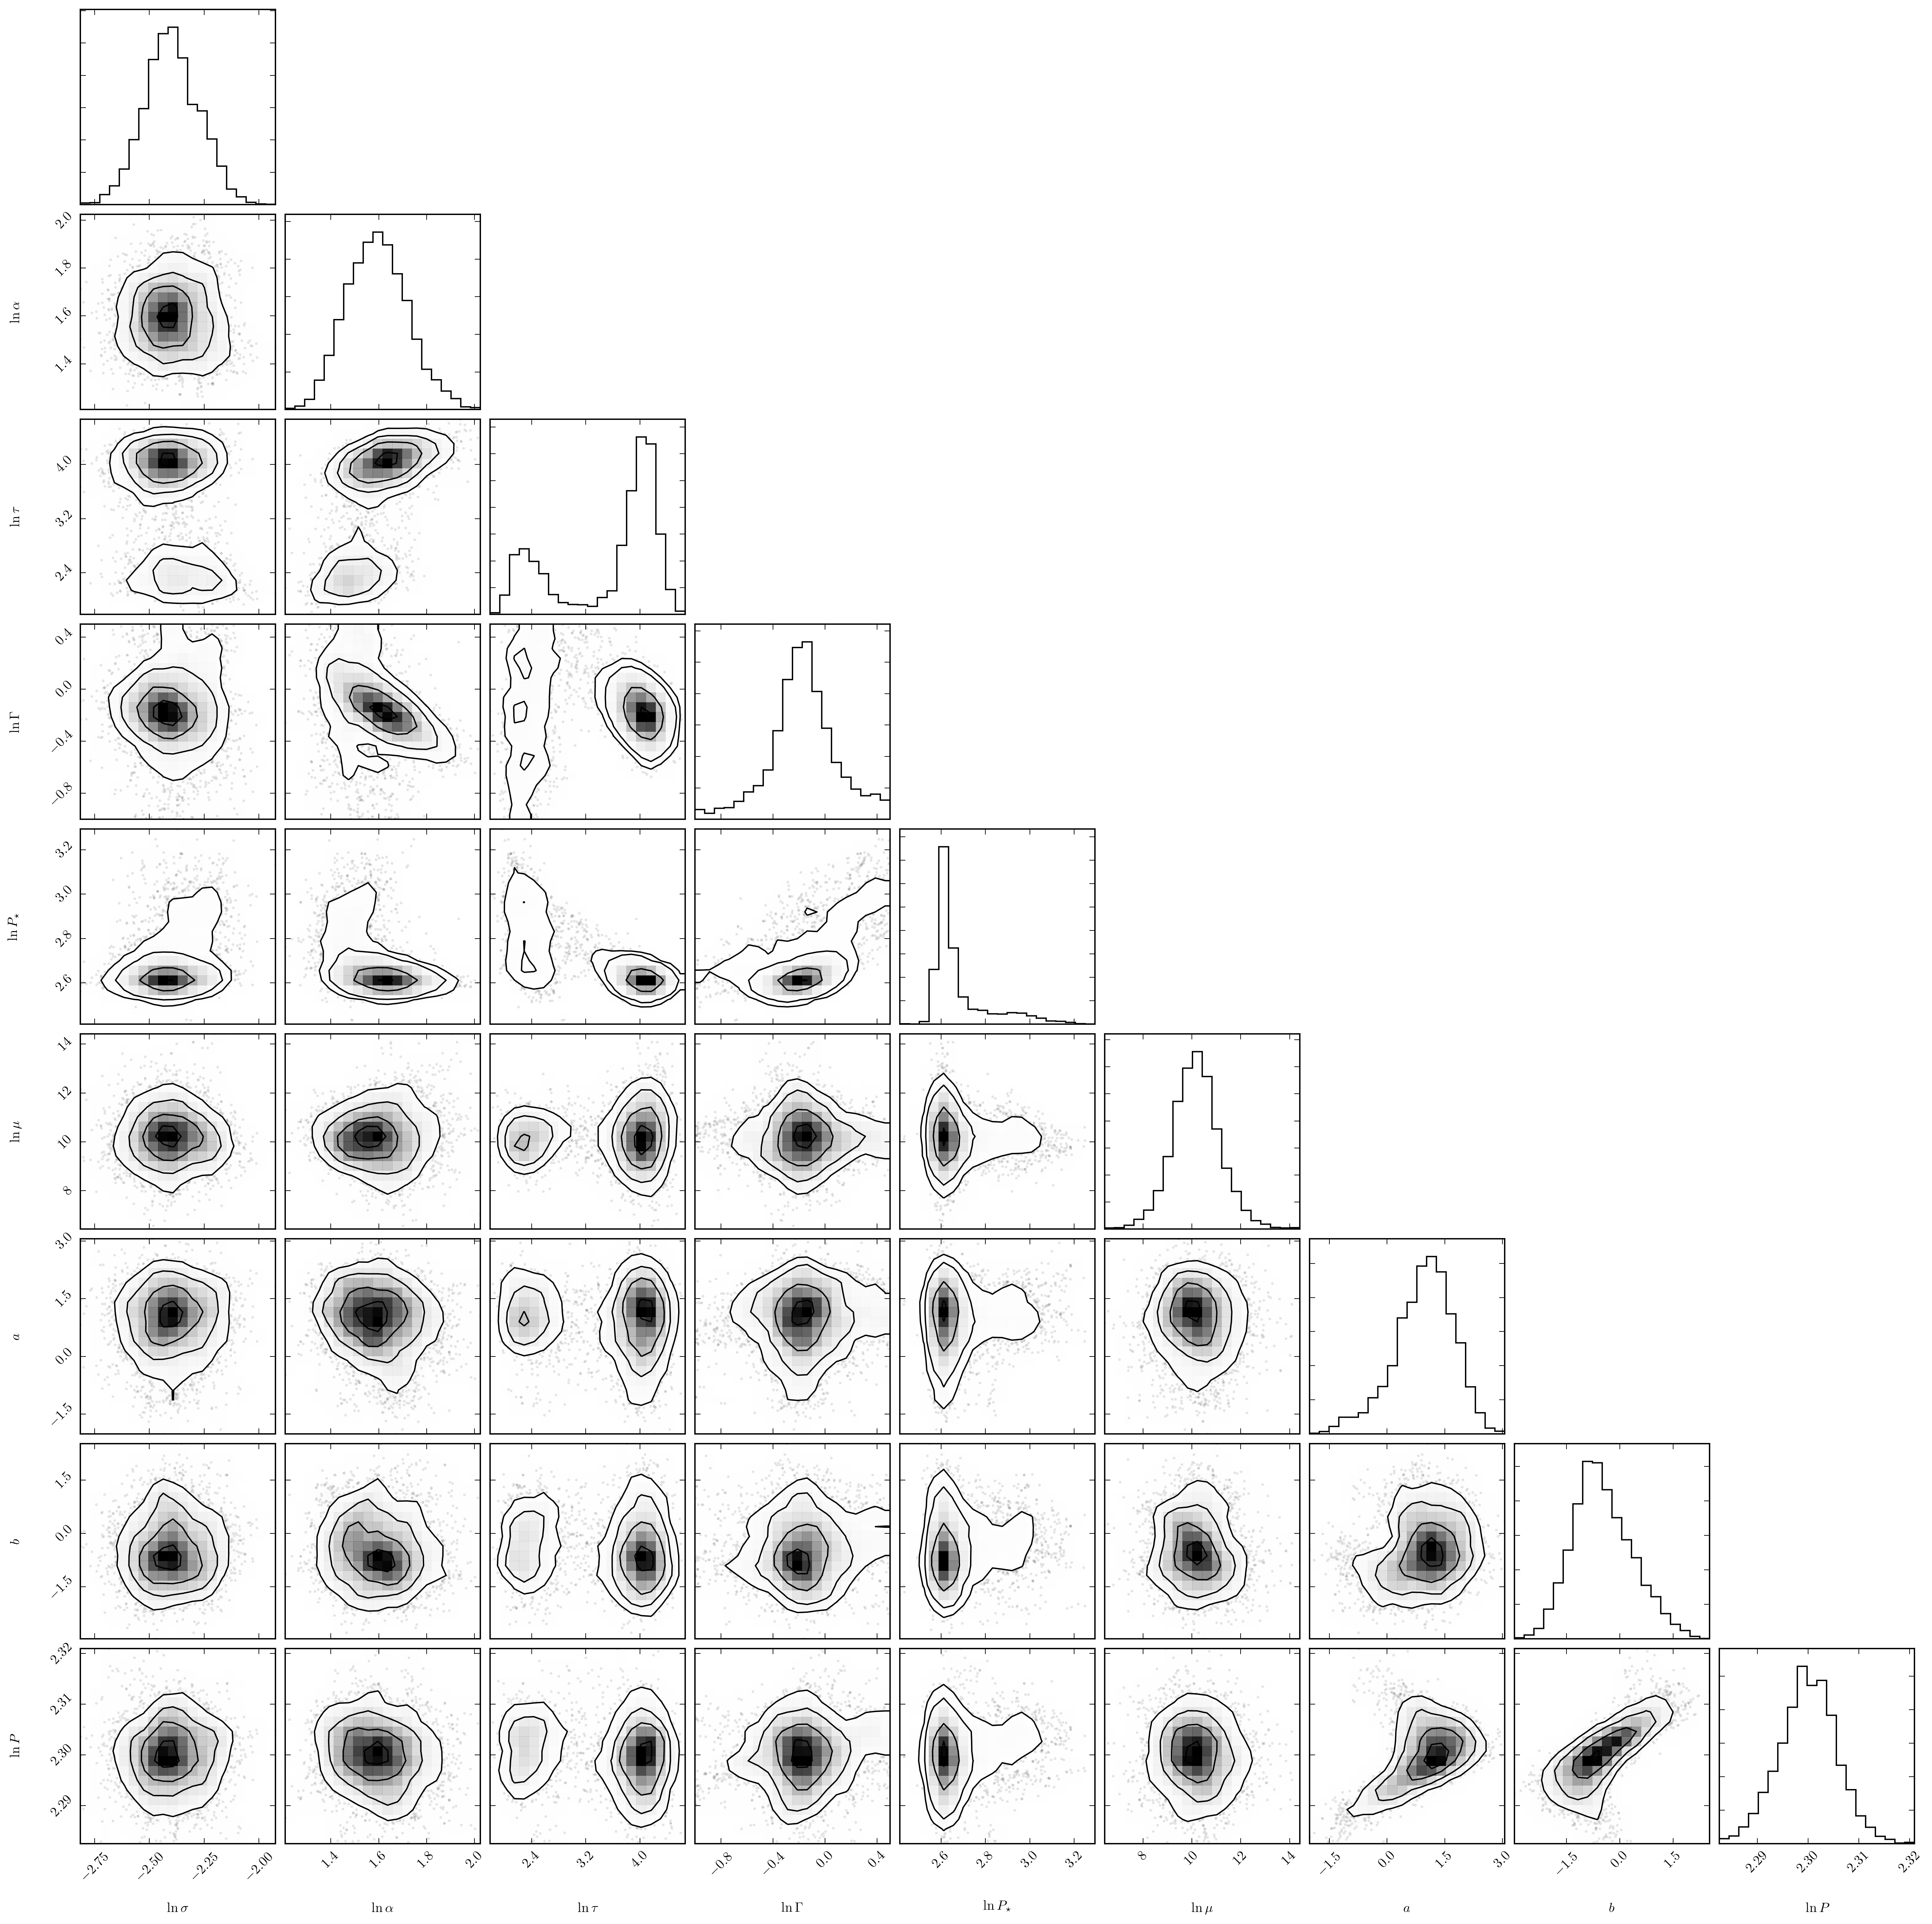

In [223]:
planet_labels = [r"$\ln \sigma$", r"$\ln \alpha$", r"$\ln \tau$", r"$\ln \Gamma$", r"$\ln P_\star$", r"$\ln \mu$",
                 r"$a$", r"$b$", r"$\ln P$"]
corner.corner(planet_samples[::13], labels=planet_labels, smooth=0.7);

We can also re-plot these samples as constraints on the semi-amplitude and period:

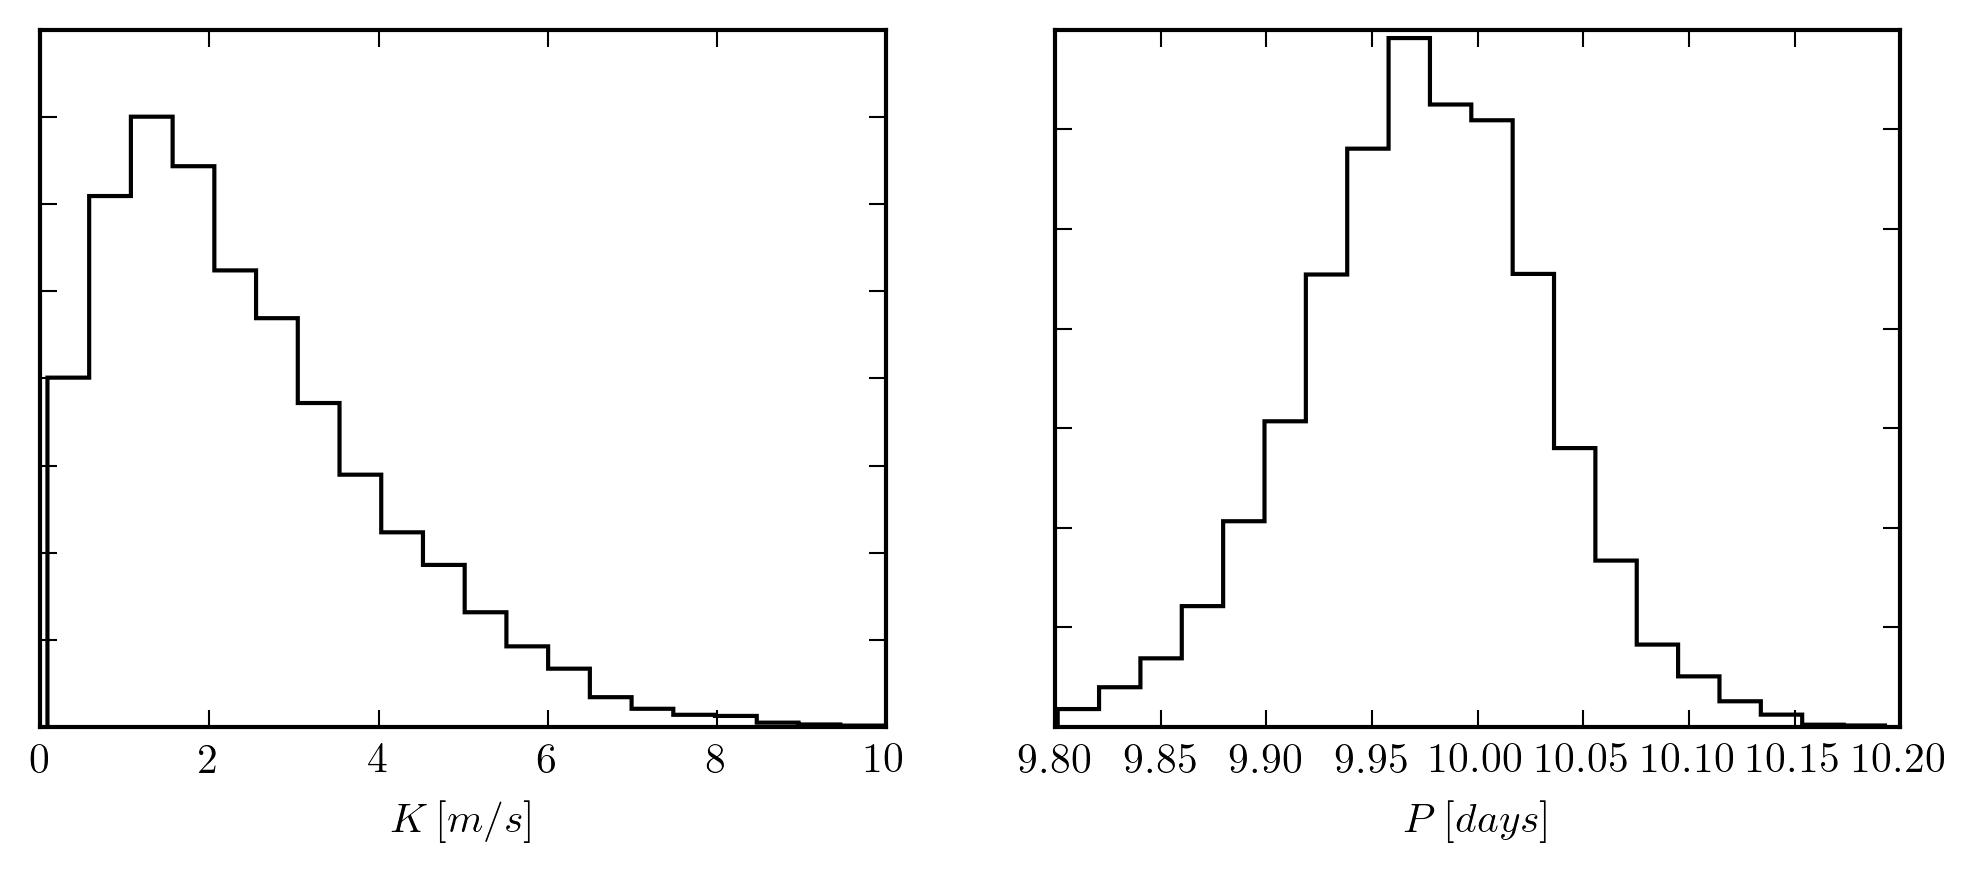

In [231]:
fig, axes = pl.subplots(1, 2, figsize=(8, 3))

ax = axes[0]
K = planet_samples[:, -3]**2 + planet_samples[:, -2]**2
ax.hist(K, 20, histtype="step", color="k")
ax.set_xlabel("$K\,[m/s]$")
ax.set_yticklabels([])

ax = axes[1]
ax.hist(np.exp(planet_samples[:, -1]), 20, histtype="step", color="k")
ax.set_xlabel("$P\,[days]$")
ax.set_yticklabels([]);

## Posterior predictive checks

A full discussion of how to determine the existence of a planet in the data is beyond the scope of this tutorial but one useful method that can be applied using just what we've done so far is a *posterior predictive check*.

In [196]:
left_out_like = np.empty((2, 1000))

for i, (pred, samps) in enumerate([(gp_predict, gp_samples), (planet_predict, planet_samples)]):
    for j, ind in enumerate(np.random.randint(len(samps), size=left_out_like.shape[1])):
        p = samps[ind]

        mu, cov = pred(validation_data[:, 0], p, time, rvel)
        cov[np.diag_indices_from(cov)] += np.exp(2 * best_p[0])

        resid = validation_data[:, 2] - mu
        left_out_like[i, j] = -0.5*np.dot(resid, np.linalg.solve(cov, resid)) - 0.5*np.linalg.slogdet(cov)[1]

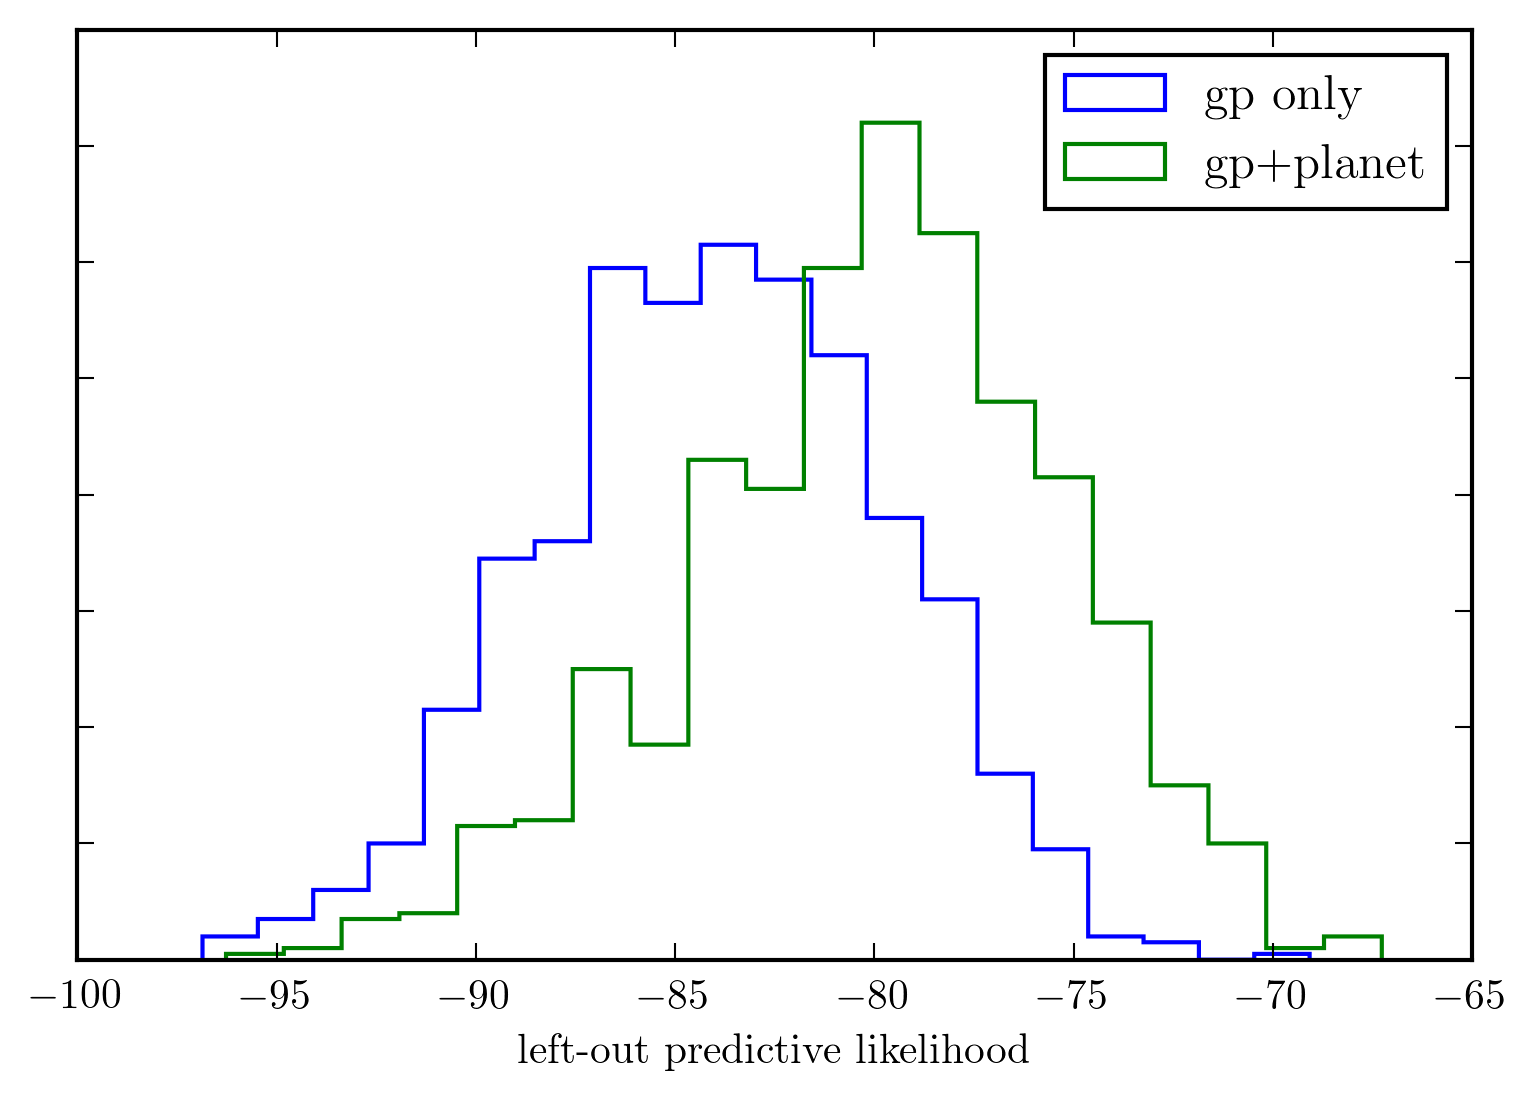

In [200]:
pl.hist(left_out_like[0], 20, histtype="step", label="gp only")
pl.hist(left_out_like[1], 20, histtype="step", label="gp+planet")
pl.legend()
pl.gca().set_yticklabels([])
pl.xlabel("left-out predictive likelihood");